## Installing required libraries

In [1]:
%%capture
%pip install h5py tensorflow keras scikit-learn

## Downloading datasets

In [2]:
%%capture
!wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

## Imports

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import callbacks
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Reading in datasets

In [4]:
photon_dataset = h5py.File('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
electron_dataset = h5py.File('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')

In [5]:
list(photon_dataset.keys())

['X', 'y']

In [6]:
photon_dataset['X'].shape

(249000, 32, 32, 2)

In [7]:
datasets = [photon_dataset, electron_dataset]
X = np.concatenate([dataset['X'] for dataset in datasets])
y = np.concatenate([dataset['y'] for dataset in datasets])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=35)

In [9]:
# Clearing the RAM to avoid crashing the runtime
del X
del y

## Defining the early stopping and learning rate callbacks

In [10]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

## Defining the model architecture, compiling and fitting

In [11]:
# Define the model architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

print(model.summary())

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC', 'binary_accuracy'])

# Train the model
history = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_schedule])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 6

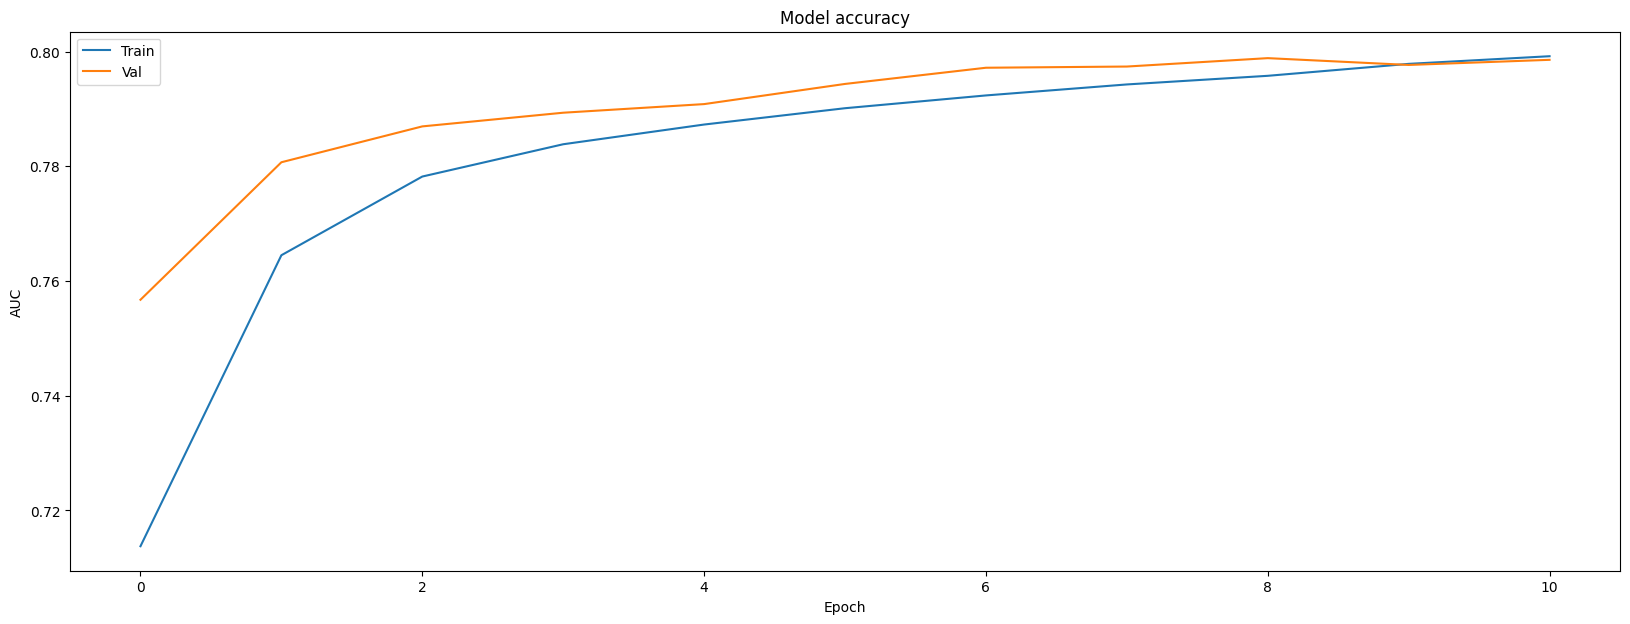

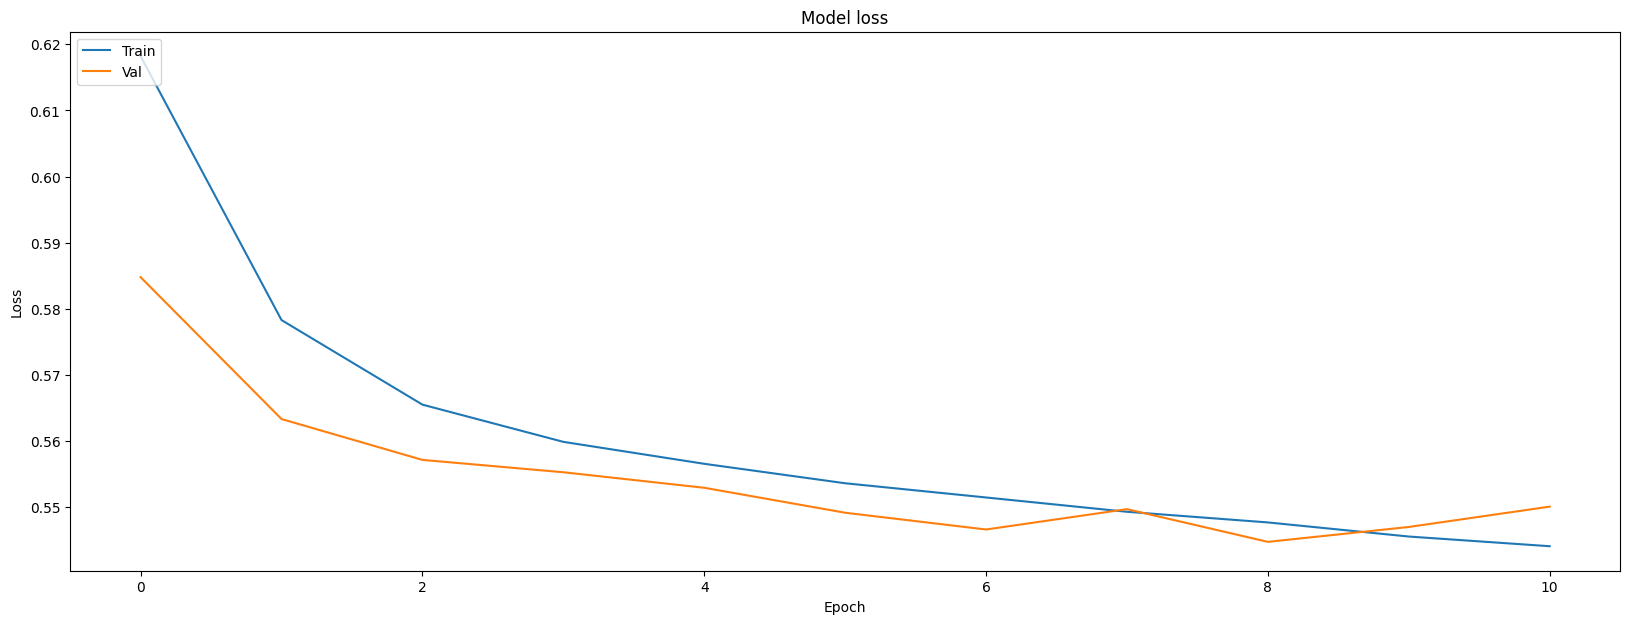

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7))

# Plot the training and validation accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model accuracy')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [13]:
y_preds = model.predict(X_test)

3113/3113 [==============================] - 6s 2ms/step


In [14]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_preds)
print(f"ROC AUC score: {score:.4f}")

ROC AUC score: 0.7981
